In [1]:
import numpy as np
import scipy as sp
import pandas as pd

# Datos de la estrella (DATOS DEL MODELO DE PRUEBA)
X = 0.85
Y = 0.10
Z = 1 - X - Y
Mtot = 5.1

#Peso molecular medio
mu = 1/(2*X + (3/4)*Y + (1/2)*Z)

#Tolerancia en nuestras comparaciones
Erelmax = 0.0001

#Valores iniciales (DATOS DEL MODELO DE PRUEBA)// Estos son los valores que debemos optimizar con el fin de minimizar el error 
# relativo en el empalme de las integraciones
Rtot = 10.982
Ltot = 22.382
Tcentral = 1.5

Rini = 0.9*Rtot

#Paso de integracion
h = -Rini/100
#Array del radio
radio = np.arange(Rini,0,h)
radio = np.append(radio,0)
#Constantes que aparecen en el calculo
A1 = 1.9022*mu*Mtot
A2 = 10.645*(Mtot/(mu*Z*(1+X)*Ltot))**(1/2)
Cp = 8.084*mu
Ct = 0.01679*Z*(1+X)*mu**2
Cm = 0.01523*mu
Ct_prima = 3.324*mu
A3 = 0.4*8.08435*mu*Mtot

#Arrays donde iremos guardando los resultados de cada capa iesima
temperatura = np.zeros_like(radio)
presion = np.zeros_like(radio)
masa = np.zeros_like(radio)
luminosidad = np.zeros_like(radio)
gradiente_presion = np.zeros_like(radio)
gradiente_temperatura = np.zeros_like(radio)
gradiente_masa = np.zeros_like(radio)
gradiente_luminosidad = np.zeros_like(radio)
epsilon_ciclo_PP = np.zeros_like(radio)
epsilon_ciclo_CN = np.zeros_like(radio)
presion_estimada = np.zeros_like(radio)
delta1_presion = np.zeros_like(radio)
delta2_presion = np.zeros_like(radio)
temperatura_estimada = np.zeros_like(radio)
delta1_temperatura = np.zeros_like(radio)
presion_calculada = np.zeros_like(radio)
temperatura_calculada = np.zeros_like(radio) 
delta1_temperatura = np.zeros_like(radio)
masa_calculada = np.zeros_like(radio)
delta1_masa = np.zeros_like(radio)
delta1_luminosidad = np.zeros_like(radio)
delta2_luminosidad = np.zeros_like(radio)
luminosidad_calculada = np.zeros_like(radio)
parametro_transporte = np.zeros_like(radio)

In [2]:
#--------------------------------------- GENERACION DE ENERGIA ---------------------------------------------------------

In [3]:
def ciclo_PP(temperatura):
    
    if ( temperatura[i] > 0.4 and temperatura[i] < 0.6 ):
        
        nuPP = 6
        epsilon1PP = 10**(-6.84)
        
    elif ( temperatura[i] >= 0.6 and temperatura[i] < 0.95 ):
        
        nuPP = 5
        epsilon1PP = 10**(-6.04)
        
    elif ( temperatura[i] >= 0.95 and temperatura[i] < 1.2 ):
        
        nuPP = 4.5
        epsilon1PP = 10**(-5.56)
        
    elif ( temperatura[i] >= 1.2 and temperatura[i] < 1.65 ):
        
        nuPP = 4
        epsilon1PP = 10**(-5.02)
        
    elif ( temperatura[i] >= 1.65 and temperatura[i] < 2.4 ):
        
        nuPP = 3.5
        epsilon1PP = 10**(-4.40)
        
    else :
        
        nuPP = 1
        epsilon1PP = 0
    
    epsilon_ciclo_PP[i] = epsilon1PP*X*X*(10*temperatura[i])**nuPP
    return nuPP, epsilon1PP

In [4]:
def ciclo_CN(temperatura):
    
    if ( temperatura[i] > 1.2 and temperatura[i] < 1.6 ):
        
        nuCN = 20
        epsilon1CN = 10**(-22.2)
    
    elif ( temperatura[i] >= 1.6 and temperatura[i] < 2.25 ):
        
        nuCN = 18
        epsilon1CN = 10**(-19.8)
        
    elif ( temperatura[i] >= 2.25 and temperatura[i] < 2.75 ):
        
        nuCN = 16
        epsilon1CN = 10**(-17.1)
        
    elif ( temperatura[i] >= 2.75 and temperatura[i] < 3.6 ):
        
        nuCN = 15
        epsilon1CN = 10**(-15.6)
        
    elif ( temperatura[i] >= 3.6 and temperatura[i] < 5 ):
        
        nuCN = 13
        epsilon1CN = 10**(-12.5)
        
    else :
        
        nuCN = 1
        epsilon1CN = 0
        
    epsilon_ciclo_CN[i] = epsilon1CN*X*(Z/3)*(10*temperatura[i])**nuCN
    return nuCN, epsilon1CN

In [5]:
def generacion_energia(temperatura):
    
    nuPP, epsilon1PP = ciclo_PP(temperatura)
    nuCN, epsilon1CN = ciclo_CN(temperatura)
    
    if (epsilon_ciclo_PP[i] > epsilon_ciclo_CN[i]):
        
        Cl = 0.01845*epsilon1PP*X*X*(10**nuPP)*(mu**2)
        ciclo = "PP"
        nu = nuPP
        
    elif (epsilon_ciclo_PP[i] <= epsilon_ciclo_CN[i]):
        
        Cl = 0.01845*epsilon1CN*X*(Z/3)*(10**nuCN)*(mu**2)
        ciclo = "CN"
        nu = nuCN
        
    return nu, Cl, ciclo   

In [6]:
#----------------------------------------ENVOLTURA RADIATIVA -----------------------------------------------------------

In [7]:
# En esta parte del codigo consideramos masa y luminosidad constante. Funcion valida para valores iniciales y A.1.1.
def paso1(radio):
    
    temperatura[i] = A1*(1/radio[i] - 1/Rtot)
    presion[i] = A2*temperatura[i]**4.25
    masa[i] = Mtot
    luminosidad[i] = Ltot
    
    nu, Cl, ciclo = generacion_energia(temperatura)
    
    gradiente_presion[i] = -Cp*(presion[i]/temperatura[i])*(masa[i]/radio[i]**2)
    gradiente_temperatura[i] = -Ct*(presion[i]**2/temperatura[i]**8.5)*(luminosidad[i]/radio[i]**2)
    gradiente_masa[i] = Cm*(presion[i]/temperatura[i])*radio[i]**2
    gradiente_luminosidad[i] = Cl*presion[i]**2*temperatura[i]**(nu-2)*radio[i]**2

In [8]:
def paso2_a11(radio):
    
    delta1_presion[i-1] = h*gradiente_presion[i-1] - h*gradiente_presion[i-2]
    delta2_presion[i-1] = h*gradiente_presion[i-1] - 2*h*gradiente_presion[i-2] + h*gradiente_presion[i-3]
    presion_estimada[i] = presion[i-1] + h*gradiente_presion[i-1] + (1/2)*delta1_presion[i-1] + (5/12)*delta2_presion[i-1]
    
    delta1_temperatura[i-1] = h*gradiente_temperatura[i-1] - h*gradiente_temperatura[i-2]
    temperatura_estimada[i] = temperatura[i-1] + h*gradiente_temperatura[i-1] + (1/2)*delta1_temperatura[i-1]

In [9]:
def paso4_a11(radio):
    
    gradiente_presion[i] = -Cp*(presion_estimada[i]/temperatura_estimada[i])*(masa[i]/radio[i]**2)
    delta1_presion[i] = h*gradiente_presion[i] - h*gradiente_presion[i-1]
    presion_calculada[i] = presion[i-1] + h*gradiente_presion[i] - (1/2)*delta1_presion[i]

In [10]:
def paso5_a11(radio):
    
    while( abs(presion_calculada[i] - presion_estimada[i])/presion_calculada[i] > Erelmax ):
        
        presion_estimada[i] = presion_calculada[i]
        paso4_a11(radio)
        
    presion[i] = presion_calculada[i]

In [11]:
def paso7_a11(radio):
    
    gradiente_temperatura[i] = -Ct*(presion_calculada[i]**2/temperatura_estimada[i]**8.5)*(Ltot/radio[i]**2)
    delta1_temperatura[i] = h*gradiente_temperatura[i] - h*gradiente_temperatura[i-1]
    temperatura_calculada[i] = temperatura[i-1] + h*gradiente_temperatura[i] - (1/2)*delta1_temperatura[i]

In [12]:
def paso8_a11(radio):
    
    while( abs(temperatura_calculada[i] - temperatura_estimada[i])/temperatura_calculada[i] > Erelmax ):
        
        temperatura_estimada[i] = temperatura_calculada[i]
        
        paso4_a11(radio)
        paso5_a11(radio)
        paso7_a11(radio)
        
    temperatura[i] = temperatura_calculada[i]

In [13]:
def paso3_a11(radio):
    
    gradiente_masa[i] = Cm*(presion_calculada[i]/temperatura_calculada[i])*radio[i]**2
    delta1_masa[i] = h*gradiente_masa[i] - h*gradiente_masa[i-1]
    masa_calculada[i] = Mtot + h*gradiente_masa[i] - (1/2)*delta1_masa[i]
    
    masa[i] = masa_calculada[i]

In [14]:
def paso1_a12(radio):
    
    temperatura[i] = A1*(1/radio[i] - 1/Rtot)
    presion[i] = A2*temperatura[i]**4.25
    masa[i] = masa_calculada[i]
    luminosidad[i] = Ltot
    
    #nu, Cl, ciclo = generacion_energia(temperatura)
    
    gradiente_presion[i] = -Cp*(presion[i]/temperatura[i])*(masa[i]/radio[i]**2)
    gradiente_temperatura[i] = -Ct*(presion[i]**2/temperatura[i]**8.5)*(luminosidad[i]/radio[i]**2)
    gradiente_masa[i] = Cm*(presion[i]/temperatura[i])*radio[i]**2
    #gradiente_luminosidad[i] = Cl*presion[i]**2*temperatura[i]**(nu-2)*radio[i]**2

In [15]:
def paso3_a12(radio):
    
    gradiente_masa[i] = Cm*(presion_estimada[i]/temperatura_estimada[i])*radio[i]**2
    delta1_masa[i] = h*gradiente_masa[i] - h*gradiente_masa[i-1]
    masa_calculada[i] = masa[i-1] + h*gradiente_masa[i] - (1/2)*delta1_masa[i]
    
    masa[i] = masa_calculada[i] 

In [16]:
def paso4_a12(radio):
    
    gradiente_presion[i] = -Cp*(presion_estimada[i]/temperatura_estimada[i])*(masa_calculada[i]/radio[i]**2)
    delta1_presion[i] = h*gradiente_presion[i] - h*gradiente_presion[i-1]
    presion_calculada[i] = presion[i-1] + h*gradiente_presion[i] - (1/2)*delta1_presion[i]

In [17]:
def paso5_a12(radio):
    
    while( abs(presion_calculada[i] - presion_estimada[i])/presion_calculada[i] > Erelmax ):
        
        presion_estimada[i] = presion_calculada[i]
        paso3_a12(radio)
        paso4_a12(radio)
        
    presion[i] = presion_calculada[i]

In [18]:
def paso8_a12(radio):
    
    while( abs(temperatura_calculada[i] - temperatura_estimada[i])/temperatura_calculada[i] > Erelmax ):
        
        temperatura_estimada[i] = temperatura_calculada[i]
        
        paso3_a12(radio)
        paso4_a12(radio)
        paso5_a12(radio)
        paso7_a11(radio)
            
    temperatura[i] = temperatura_calculada[i] 

In [19]:
def paso6_a12(radio):

    nu, Cl, ciclo = generacion_energia(temperatura)
    
    gradiente_luminosidad[i] = Cl*(presion_calculada[i]**2)*(temperatura_calculada[i])**(nu-2)*radio[i]**2
    delta1_luminosidad[i] = h*gradiente_luminosidad[i] - h*gradiente_luminosidad[i-1]
    delta2_luminosidad[i] = h*gradiente_luminosidad[i] - 2*h*gradiente_luminosidad[i-1] + h*gradiente_luminosidad[i-2]
    luminosidad_calculada[i] = Ltot + h*gradiente_luminosidad[i] - (1/2)*delta1_luminosidad[i] - (1/12)*delta2_luminosidad[i]
    
    luminosidad[i] = luminosidad_calculada[i]

Funciones para el algoritmo A.1.3.

In [20]:
def paso9_a13(radio):
    
    parametro_transporte[i] = (temperatura_calculada[i]/presion_calculada[i])*(gradiente_presion[i]/gradiente_temperatura[i])

In [21]:
def paso1_a13(radio):
    
    temperatura[i] = A1*(1/radio[i] - 1/Rtot)
    presion[i] = A2*temperatura[i]**4.25
    masa[i] = masa_calculada[i]
    luminosidad[i] = luminosidad_calculada[i]
    
    nu, Cl, ciclo = generacion_energia(temperatura)
    
    gradiente_presion[i] = -Cp*(presion[i]/temperatura[i])*(masa[i]/radio[i]**2)
    gradiente_temperatura[i] = -Ct*(presion[i]**2/temperatura[i]**8.5)*(luminosidad[i]/radio[i]**2)
    gradiente_masa[i] = Cm*(presion[i]/temperatura[i])*radio[i]**2
    gradiente_luminosidad[i] = Cl*presion[i]**2*temperatura[i]**(nu-2)*radio[i]**2

In [22]:
def paso6_a13(radio):
    
    temperatura[i] = temperatura_estimada[i]
    
    nu, Cl, ciclo = generacion_energia(temperatura)
    
    gradiente_luminosidad[i] = Cl*(presion_calculada[i]**2)*(temperatura_estimada[i])**(nu-2)*radio[i]**2
    delta1_luminosidad[i] = h*gradiente_luminosidad[i] - h*gradiente_luminosidad[i-1]
    delta2_luminosidad[i] = h*gradiente_luminosidad[i] - 2*h*gradiente_luminosidad[i-1] + h*gradiente_luminosidad[i-2]
    luminosidad_calculada[i] = luminosidad[i-1] + h*gradiente_luminosidad[i] - (1/2)*delta1_luminosidad[i] - (1/12)*delta2_luminosidad[i]
    
    luminosidad[i] = luminosidad_calculada[i]

In [23]:
def paso7_a13(radio):
    
    gradiente_temperatura[i] = -Ct*(presion_calculada[i]**2/temperatura_estimada[i]**8.5)*(luminosidad_calculada[i]/radio[i]**2)
    delta1_temperatura[i] = h*gradiente_temperatura[i] - h*gradiente_temperatura[i-1]
    temperatura_calculada[i] = temperatura[i-1] + h*gradiente_temperatura[i] - (1/2)*delta1_temperatura[i]

In [24]:
def paso8_a13(radio):
    
    while( abs(temperatura_calculada[i] - temperatura_estimada[i])/temperatura_calculada[i] > Erelmax ):
        
        temperatura_estimada[i] = temperatura_calculada[i]
        
        paso3_a12(radio)
        paso4_a12(radio)
        paso5_a12(radio)
        paso6_a13(radio)
        paso7_a13(radio)
        
    temperatura[i] = temperatura_calculada[i]

Funciones para el algoritmo A.2.

In [25]:
def paso1_a2(radio):
    
    temperatura[i] = A3*(1/radio[i] - 1/Rtot)
    presion[i] = k_prima*temperatura[i]**2.5
    masa[i] = masa_calculada[i]
    luminosidad[i] = luminosidad_calculada[i]
    
    nu, Cl, ciclo = generacion_energia(temperatura)
    
    gradiente_presion[i] = -Cp*(presion[i]/temperatura[i])*(masa[i]/radio[i]**2)
    gradiente_temperatura[i] = -Ct*(presion[i]**2/temperatura[i]**8.5)*(luminosidad[i]/radio[i]**2)
    gradiente_masa[i] = Cm*(presion[i]/temperatura[i])*radio[i]**2
    gradiente_luminosidad[i] = Cl*presion[i]**2*temperatura[i]**(nu-2)*radio[i]**2
    
    

In [26]:
def paso2_a2(radio):
    
    delta1_temperatura[i-1] = h*gradiente_temperatura[i-1] - h*gradiente_temperatura[i-2]
    temperatura_estimada[i] = temperatura[i-1] + h*gradiente_temperatura[i-1] + (1/2)*delta1_temperatura[i-1]
    
    presion_estimada[i] = k_prima*(temperatura_estimada[i]**2.5)

In [27]:
def paso7_a2(radio):
    
    if(radio[i] == 0):
        
        temperatura_calculada[i] = temperatura_estimada[i]
        presion_calculada[i] = presion_estimada[i]
        
    else:
        
        gradiente_temperatura[i] = -Ct_prima*(masa_calculada[i]/radio[i]**2)
        delta1_temperatura[i] = h*gradiente_temperatura[i] - h*gradiente_temperatura[i-1]
        temperatura_calculada[i] = temperatura[i-1] + h*gradiente_temperatura[i] - (1/2)*delta1_temperatura[i]

In [28]:
def paso8_a2(radio):
    
    while( abs(temperatura_calculada[i] - temperatura_estimada[i])/temperatura_calculada[i] > Erelmax ):
        
        temperatura_estimada[i] = temperatura_calculada[i]
        
        presion_estimada[i] = k_prima*(temperatura_estimada[i]**2.5)
        paso3_a12(radio)
        paso7_a2(radio)
    
    temperatura[i] = temperatura_calculada[i]
    presion_calculada[i] = k_prima*(temperatura_calculada[i]**2.5)
    presion[i] = presion_calculada[i]

In [29]:
def paso6_a2(radio):
    
    nu, Cl, ciclo = generacion_energia(temperatura)
    
    gradiente_luminosidad[i] = Cl*(presion_calculada[i]**2)*(temperatura_calculada[i]**(nu-2))*radio[i]**2
    delta1_luminosidad[i] = h*gradiente_luminosidad[i] - h*gradiente_luminosidad[i-1]
    delta2_luminosidad[i] = h*gradiente_luminosidad[i] - 2*h*gradiente_luminosidad[i-1] + h*gradiente_luminosidad[i-2]
    luminosidad_calculada[i] = luminosidad[i-1] + h*gradiente_luminosidad[i] - (1/2)*delta1_luminosidad[i] - (1/12)*delta2_luminosidad[i]
    
    luminosidad[i] = luminosidad_calculada[i]

# EJECUCION DEL CODIGO

In [30]:
#INTEGRACION DESDE LA SUPERFICIE

print("E", "fase", "i", "radio", "presion", "temperatura", "luminosidad", "masa")

i = 0

while (i <=2 ):
    
    paso1(radio)
    print("--", "INICIO", i, "%.7f" % radio[i], "%.7f" % presion[i],"%.7f" % temperatura[i], "%.6f" % luminosidad[i], "%.6f" % masa[i] )
    
    i = i + 1
    
for r in radio[2:len(radio)]:
    
#Algoritmo A.1.1. Masa y Luminosidad constantes

    paso1(radio)
    paso2_a11(radio)
    paso4_a11(radio)
    paso5_a11(radio)
    paso7_a11(radio)
    paso8_a11(radio)
    paso3_a11(radio)
    
    while( abs(masa[i] - Mtot)/Mtot < Erelmax and abs( luminosidad[i] - Ltot)/Ltot < Erelmax ):
        
        paso1(radio)
        paso2_a11(radio)
        paso4_a11(radio)
        paso5_a11(radio)
        paso7_a11(radio)
        paso8_a11(radio)
        paso3_a11(radio)
    
        print("--", "A.1.1.", i, "%.7f" % radio[i], "%.7f" % presion[i],"%.7f" % temperatura[i], "%.6f" % luminosidad[i], "%.6f" % Mtot )
    
        i = i + 1 

E fase i radio presion temperatura luminosidad masa
-- INICIO 0 9.8838000 0.0000958 0.0545293 22.382000 5.100000
-- INICIO 1 9.7849620 0.0001442 0.0600373 22.382000 5.100000
-- INICIO 2 9.6861240 0.0002109 0.0656577 22.382000 5.100000
-- A.1.1. 3 9.5872860 0.0003016 0.0714025 22.382000 5.100000
-- A.1.1. 4 9.4884480 0.0004224 0.0772787 22.382000 5.100000
-- A.1.1. 5 9.3896100 0.0005806 0.0832833 22.382000 5.100000


In [31]:
#Algoritmo A.1.2. Masa variable y Luminosidad constante

for r in radio[i:len(radio)]:
    
    paso1_a12(radio)
    paso2_a11(radio)
    paso3_a12(radio)
    paso4_a12(radio)
    paso5_a12(radio)
    paso7_a11(radio)    
    paso8_a12(radio)
    paso6_a12(radio)
        
    while( abs(masa[i] - Mtot)/Mtot > Erelmax and abs( luminosidad[i] - Ltot)/Ltot < Erelmax ):
        
        paso1_a12(radio)
        paso2_a11(radio)
        paso3_a12(radio)
        paso4_a12(radio)
        paso5_a12(radio)
        paso7_a11(radio)
        paso8_a12(radio)
        paso6_a12(radio)
    
        print("--", "A.1.2.", i, "%.7f" % radio[i], "%.7f" % presion[i],"%.7f" % temperatura[i], "%.6f" % Ltot, "%.6f" % masa[i] )
        
        i = i + 1
        
#Algoritmo A.1.3. Masa y luminosidad variables
        
    paso9_a13(radio)
    
    while( parametro_transporte[i] > 2.5 ):
        
        paso1_a13(radio)
        paso2_a11(radio)
        paso3_a12(radio)
        paso4_a12(radio)
        paso5_a12(radio)
        #print(temperatura[i], temperatura_estimada[i], temperatura_calculada[i])
        paso6_a13(radio)
        nu, Cl, ciclo = generacion_energia(temperatura)
        #print(temperatura[i],nu, Cl, ciclo)
        paso7_a13(radio)
        paso8_a13(radio)
        paso9_a13(radio)
        
        print(ciclo, "A.1.3.", i, "%.7f" % radio[i], "%.7f" % presion[i],"%.7f" % temperatura[i], "%.6f" % luminosidad[i], "%.6f" % masa[i], "%.6f" % parametro_transporte[i] )
        
        i = i + 1

-- A.1.2. 6 9.2907720 0.0007852 0.0894169 22.382000 5.098963
-- A.1.2. 7 9.1919340 0.0010468 0.0956811 22.382000 5.098260
-- A.1.2. 8 9.0930960 0.0013781 0.1020797 22.382000 5.097407
-- A.1.2. 9 8.9942580 0.0017937 0.1086163 22.382000 5.096381
-- A.1.2. 10 8.8954200 0.0023110 0.1152956 22.382000 5.095159
-- A.1.2. 11 8.7965820 0.0029505 0.1221223 22.382000 5.093715
-- A.1.2. 12 8.6977440 0.0037358 0.1291012 22.382000 5.092017
-- A.1.2. 13 8.5989060 0.0046945 0.1362375 22.382000 5.090037
-- A.1.2. 14 8.5000680 0.0058588 0.1435362 22.382000 5.087738
-- A.1.2. 15 8.4012300 0.0072661 0.1510032 22.382000 5.085085
-- A.1.2. 16 8.3023920 0.0089596 0.1586436 22.382000 5.082038
-- A.1.2. 17 8.2035540 0.0109894 0.1664639 22.382000 5.078552
-- A.1.2. 18 8.1047160 0.0134132 0.1744697 22.382000 5.074583
-- A.1.2. 19 8.0058780 0.0162977 0.1826678 22.382000 5.070081
-- A.1.2. 20 7.9070400 0.0197198 0.1910642 22.382000 5.064992
-- A.1.2. 21 7.8082020 0.0237678 0.1996660 22.382000 5.059259
-- A.1.2. 22

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
#Algoritmo A.2. Nucleo Convectivo
    
k_prima = presion_calculada[i]/temperatura_calculada[i]**2.5

if( parametro_transporte[i] <= 2.5 and abs( masa[i] - Mtot)/Mtot > Erelmax and abs( luminosidad[i] - Ltot)/Ltot > Erelmax ):
        
    while( radio[i] >= 0 and i < 99):
#Paramos en la capa 99 para que no de error     
        paso1_a2(radio)
        paso2_a2(radio)
        paso3_a12(radio)
        paso7_a2(radio)
        paso8_a2(radio)
        paso6_a2(radio)
        
        nu, Cl, ciclo = generacion_energia(temperatura)
            
        print(ciclo, "CONVEC", i, "%.7f" % radio[i], "%.7f" % presion[i],"%.7f" % temperatura[i], "%.6f" % luminosidad[i], "%.6f" % masa[i], "%.6f" % parametro_transporte[i] )
        
        i = i + 1

PP CONVEC 78 2.1744360 37.9039301 1.3014324 19.400349 0.882922 2.415475
PP CONVEC 79 2.0755980 40.3806476 1.3348031 18.933921 0.770845 0.000000
PP CONVEC 80 1.9767600 42.8337847 1.3666663 18.430447 0.665135 0.000000
PP CONVEC 81 1.8779220 45.2382374 1.3968513 17.896412 0.566159 0.000000
PP CONVEC 82 1.7790840 47.5664900 1.4251755 17.339809 0.474222 0.000000
PP CONVEC 83 1.6802460 49.7884430 1.4514408 16.770241 0.389547 0.000000
PP CONVEC 84 1.5814080 51.8711228 1.4754285 16.198596 0.312280 0.000000
PP CONVEC 85 1.4825700 53.7782314 1.4968922 15.636607 0.242489 0.000000
CN CONVEC 86 1.3837320 55.4694543 1.5155472 15.095516 0.180162 0.000000
CN CONVEC 87 1.2848940 56.8993561 1.5310552 14.550589 0.125204 0.000000
CN CONVEC 88 1.1860560 58.0155972 1.5429996 13.967455 0.077433 0.000000
CN CONVEC 89 1.0872180 58.7561562 1.5508481 13.394645 0.036591 0.000000
CN CONVEC 90 0.9883800 59.0449021 1.5538922 12.875683 0.002344 0.000000
CN CONVEC 91 0.8895420 58.7843061 1.5511453 12.448194 -0.025716 

Deseamos conocer en que capa se produce la transicion radiación -> convección.

Indice de transicion en integracion up-down ----> ind_tr[0]

In [33]:
for x in parametro_transporte:
    
    if x != 0 and x < 2.5:
        
        ind_tr = np.where(parametro_transporte == x)[0]
        print(ind_tr)

[78]


In [34]:
ind_tr[0] - 1

77

Valores en la frontera (desde arriba)

In [35]:
def valoresfrontera_down(parametro_transporte, radio, presion, temperatura, luminosidad, masa):
    
    radio_transicion_down = np.interp(2.5, [parametro_transporte[ind_tr[0]-1],parametro_transporte[ind_tr[0]]],[radio[ind_tr[0]-1], radio[ind_tr[0]]])
    presion_transicion_down = np.interp(radio_transicion_down, [radio[ind_tr[0]-1],radio[ind_tr[0]]], [presion[ind_tr[0]-1], presion[ind_tr[0]]])
    temperatura_transicion_down = np.interp(radio_transicion_down, [radio[ind_tr[0]-1], radio[ind_tr[0]]], [temperatura[ind_tr[0]-1], temperatura[ind_tr[0]]])
    luminosidad_transicion_down = np.interp(radio_transicion_down, [radio[ind_tr[0]-1], radio[ind_tr[0]]], [luminosidad[ind_tr[0]-1], luminosidad[ind_tr[0]]])
    masa_transicion_down = np.interp(radio_transicion_down, [radio[ind_tr[0]-1], radio[ind_tr[0]]], [masa[ind_tr[0]-1], masa[ind_tr[0]]])
    
    return radio_transicion_down, presion_transicion_down, temperatura_transicion_down, luminosidad_transicion_down, masa_transicion_down
    
    print(radio_transicion_down)

In [36]:
valores_down = valoresfrontera_down(parametro_transporte, radio, presion, temperatura, luminosidad, masa)
print("transicion_down","%.2f" % valores_down[0],"%.2f" %  valores_down[1],"%.2f" %  valores_down[2],"%.2f" %  valores_down[3],"%.2f" %  valores_down[4])
radio_transicion_down = valores_down[0]
print(radio_transicion_down)

transicion_down 2.17 35.50 1.27 19.83 1.00
2.1744359999999485


Guardamos los resultados obtenidos en la integracion desde la superficie

In [37]:
temperatura_down = np.zeros_like(radio)
presion_down = np.zeros_like(radio)
masa_down = np.zeros_like(radio)
luminosidad_down = np.zeros_like(radio)
radio_down = np.zeros_like(radio)

#------------------------------------------------------------------------------------------------------------

temperatura_down = temperatura
presion_down = presion
masa_down = masa
luminosidad_down = luminosidad
radio_down = radio

# INTEGRACION DESDE EL CENTRO##

Invertimos el radio, redefinimos el paso de integracion (positivo) y reiniciamos los arrays con los que trabajamos

In [38]:
radio = radio[::-1]
radio
#------------------------------------------------------------------------------------------------------------
h = Rini/100
#--------------------------------------------------------------------------------------------------------------
temperatura = np.zeros_like(radio)
presion = np.zeros_like(radio)
masa = np.zeros_like(radio)
luminosidad = np.zeros_like(radio)
gradiente_presion = np.zeros_like(radio)
gradiente_temperatura = np.zeros_like(radio)
gradiente_masa = np.zeros_like(radio)
gradiente_luminosidad = np.zeros_like(radio)
epsilon_ciclo_PP = np.zeros_like(radio)
epsilon_ciclo_CN = np.zeros_like(radio)
presion_estimada = np.zeros_like(radio)
delta1_presion = np.zeros_like(radio)
delta2_presion = np.zeros_like(radio)
temperatura_estimada = np.zeros_like(radio)
delta1_temperatura = np.zeros_like(radio)
presion_calculada = np.zeros_like(radio)
temperatura_calculada = np.zeros_like(radio) 
delta1_temperatura = np.zeros_like(radio)
masa_calculada = np.zeros_like(radio)
delta1_masa = np.zeros_like(radio)
delta1_luminosidad = np.zeros_like(radio)
delta2_luminosidad = np.zeros_like(radio)
luminosidad_calculada = np.zeros_like(radio)
parametro_transporte = np.zeros_like(radio)
#---------------------------------------------------------------------------------------------------------------

In [39]:
radio

array([ 0.      ,  0.098838,  0.197676,  0.296514,  0.395352,  0.49419 ,
        0.593028,  0.691866,  0.790704,  0.889542,  0.98838 ,  1.087218,
        1.186056,  1.284894,  1.383732,  1.48257 ,  1.581408,  1.680246,
        1.779084,  1.877922,  1.97676 ,  2.075598,  2.174436,  2.273274,
        2.372112,  2.47095 ,  2.569788,  2.668626,  2.767464,  2.866302,
        2.96514 ,  3.063978,  3.162816,  3.261654,  3.360492,  3.45933 ,
        3.558168,  3.657006,  3.755844,  3.854682,  3.95352 ,  4.052358,
        4.151196,  4.250034,  4.348872,  4.44771 ,  4.546548,  4.645386,
        4.744224,  4.843062,  4.9419  ,  5.040738,  5.139576,  5.238414,
        5.337252,  5.43609 ,  5.534928,  5.633766,  5.732604,  5.831442,
        5.93028 ,  6.029118,  6.127956,  6.226794,  6.325632,  6.42447 ,
        6.523308,  6.622146,  6.720984,  6.819822,  6.91866 ,  7.017498,
        7.116336,  7.215174,  7.314012,  7.41285 ,  7.511688,  7.610526,
        7.709364,  7.808202,  7.90704 ,  8.005878, 

Condiciones iniciales

In [40]:
Mcentral = 0
Lcentral = 0
Tcentral = 2 #ponemos la que se nos da, podria ponerse la ultima temperatura de la integracion desde la superfici

Funciones para el algoritmo B

In [41]:
def paso1_b(radio):
    
    masa[i] = (Cm/3)*k_prima*Tcentral**1.5*radio[i]**3
    temperatura[i] = Tcentral - 0.008207*(mu**2)*(k_prima)*(Tcentral**1.5)*radio[i]**2
    nu, Cl, ciclo = generacion_energia(temperatura)
    #print(nu, Cl, ciclo)
    luminosidad[i] = (Cl/3)*k_prima**2*(Tcentral**(3+nu))*radio[i]**3
    presion[i] = k_prima*temperatura[i]**2.5
    
    gradiente_masa[i] = Cm*k_prima*temperatura[i]**1.5*radio[i]**2
    #gradiente_presion[i] = -Cp*k_prima*temperatura[i]**1.5*(masa[i]/radio[i]**2)
    gradiente_luminosidad[i] = Cl*(k_prima**2)*(temperatura[i]**(3+nu))*radio[i]**2
    gradiente_temperatura[i] = -Ct_prima*(masa[i]/radio[i]**2)

# EJECUCION DEL CODIGO

In [42]:
#INTEGRACION DESDE EL CENTRO

print("E", "fase", "i", "radio", "presion", "temperatura", "luminosidad", "masa")

i = 0

while (i <=2 ):
    
    paso1_b(radio)
    nu, Cl, ciclo = generacion_energia(temperatura)
    
    print("--", "CONVEC", i, "%.7f" % radio[i], "%.7f" % presion[i],"%.7f" % temperatura[i], "%.6f" % luminosidad[i], "%.6f" % masa[i] )
    
    i = i + 1

E fase i radio presion temperatura luminosidad masa
-- CONVEC 0 0.0000000 110.9699048 2.0000000 0.000000 0.000000
-- CONVEC 1 0.0988380 110.7795543 1.9986270 0.332093 0.000151
-- CONVEC 2 0.1976760 110.2096786 1.9945081 2.656746 0.001209


C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [43]:
for r in radio[i:len(radio)]:
    
    while(radio[i] <= radio_transicion_down):
        
        paso1_b(radio)
        paso2_a2(radio)
        paso3_a12(radio)
        paso7_a2(radio)
        paso8_a2(radio)
        paso6_a2(radio)
            
        nu, Cl, ciclo = generacion_energia(temperatura)
        
        print(ciclo, "CONVEC", i, "%.7f" % radio[i], "%.7f" % presion[i],"%.7f" % temperatura[i], "%.6f" % luminosidad[i], "%.6f" % masa[i] )
    
        i = i + 1
        
        

CN CONVEC 3 0.2965140 109.2298070 1.9873958 8.354147 0.004132
CN CONVEC 4 0.3953520 107.8659883 1.9774327 18.508727 0.009718
CN CONVEC 5 0.4941900 106.1425750 1.9647340 33.370736 0.018799
CN CONVEC 6 0.5930280 104.0785804 1.9493618 52.473616 0.032167
CN CONVEC 7 0.6918660 101.6944318 1.9313758 74.770250 0.050557
CN CONVEC 8 0.7907040 99.0129693 1.9108418 98.855793 0.074641
CN CONVEC 9 0.8895420 96.0593976 1.8878342 123.221693 0.105022
CN CONVEC 10 0.9883800 92.8609832 1.8624354 146.487173 0.142224
CN CONVEC 11 1.0872180 89.4466626 1.8347359 167.568336 0.186685
CN CONVEC 12 1.1860560 85.8466166 1.8048337 185.765813 0.238757
CN CONVEC 13 1.2848940 82.0918321 1.7728333 200.772799 0.298698
CN CONVEC 14 1.3837320 78.2136655 1.7388454 212.621143 0.366673
CN CONVEC 15 1.4825700 74.2434174 1.7029861 221.591103 0.442749
CN CONVEC 16 1.5814080 70.2119269 1.6653759 228.110468 0.526899
CN CONVEC 17 1.6802460 66.1491921 1.6261392 232.663286 0.619002
CN CONVEC 18 1.7790840 62.0840241 1.5854037 235.7

Queremos conocer el indice de la capa en la cual se produce la transicion conveccion -> radiacion. Utilizamos la longitud del array de temperatura de forma indiferente, cualquier array hubiera sido utilizado ya que solo queremos conocer su longitud que es igual para todos los parametros.

Indice de transicion en integracion down-up ---> ind_trans[0]

In [44]:
ind_trans = len(temperatura) - ind_tr - 1
print(ind_trans[0])

22


Valores en la frontera(desde el centro)

In [45]:
def valoresfrontera_up(radio, presion, temperatura, luminosidad, masa):
    
    presion_transicion_up = np.interp(radio_transicion_down, [radio[ind_trans[0]-1],radio[ind_trans[0]]], [presion[ind_trans[0]-1], presion[ind_trans[0]]])
    temperatura_transicion_up = np.interp(radio_transicion_down, [radio[ind_trans[0]-1], radio[ind_trans[0]]], [temperatura[ind_trans[0]-1], temperatura[ind_trans[0]]])
    luminosidad_transicion_up = np.interp(radio_transicion_down, [radio[ind_trans[0]-1], radio[ind_trans[0]]], [luminosidad[ind_trans[0]-1], luminosidad[ind_trans[0]]])
    masa_transicion_up = np.interp(radio_transicion_down, [radio[ind_trans[0]-1], radio[ind_trans[0]]], [masa[ind_trans[0]-1], masa[ind_trans[0]]])
    
    return presion_transicion_up, temperatura_transicion_up, luminosidad_transicion_up, masa_transicion_up

In [46]:
valores_up = valoresfrontera_up(radio, presion, temperatura, luminosidad, masa)
print("transicion_up","%.2f" % radio_transicion_down ,"%.2f" % valores_up[0],"%.2f" %  valores_up[1],"%.2f" %  valores_up[2],"%.2f" %  valores_up[3])

transicion_up 2.17 46.32 1.41 240.61 1.19


Guardamos los resultados obtenidos en la integracion desde el centro

In [47]:
temperatura_up = np.zeros_like(radio)
presion_up = np.zeros_like(radio)
masa_up = np.zeros_like(radio)
luminosidad_up = np.zeros_like(radio)
radio_up = np.zeros_like(radio)

#------------------------------------------------------------------------------------------------------------

temperatura_up = temperatura
presion_up = presion
masa_up = masa
luminosidad_up = luminosidad
radio_up = radio

# AJUSTE DE LAS SOLUCIONES A UN RADIO INTERMEDIO

In [48]:
valores_up = valoresfrontera_up(radio, presion, temperatura, luminosidad, masa)
print("transicion_down","%.4f" % valores_down[0],"%.4f" %  valores_down[1],"%.4f" %  valores_down[2],"%.4f" %  valores_down[3],"%.4f" %  valores_down[4])
print("transicion_up","%.4f" % radio_transicion_down ,"%.4f" % valores_up[0],"%.4f" %  valores_up[1],"%.4f" %  valores_up[2],"%.4f" %  valores_up[3])

radio_transicion_down, presion_transicion_down, temperatura_transicion_down, luminosidad_transicion_down, masa_transicion_down = valores_down
presion_transicion_up, temperatura_transicion_up, luminosidad_transicion_up, masa_transicion_up = valores_up

Err_rel_presion = abs(presion_transicion_down - presion_transicion_up)/presion_transicion_down*100
Err_rel_temperatura = abs( temperatura_transicion_down - temperatura_transicion_up)/temperatura_transicion_down*100
Err_rel_luminosidad = abs( luminosidad_transicion_down - luminosidad_transicion_up)/luminosidad_transicion_down*100
Err_rel_masa = abs(masa_transicion_down - masa_transicion_up)/masa_transicion_up*100

Err_rel_total = (Err_rel_presion**2 + Err_rel_temperatura**2 + Err_rel_luminosidad**2 + Err_rel_masa**2)**0.5

print("Err.relat(%) -->","%.2f" % Err_rel_presion,"%.2f" % Err_rel_temperatura,"%.2f" % Err_rel_luminosidad,"%.2f" % Err_rel_masa,"%.2f" % Err_rel_total)


transicion_down 2.1744 35.5027 1.2693 19.8276 1.0009
transicion_up 2.1744 46.3175 1.4101 240.6070 1.1884
Err.relat(%) --> 30.46 11.09 1113.50 15.77 1114.08


## CÁLCULO DE LA TEMPERATURA CENTRAL QUE MINIMIZA EL ERROR RELATIVO TOTAL

In [49]:
temps = np.arange(1,2.5,0.001)
#Error_total = np.zeros(len(temps))
Error_total = []

for Tcentral in temps:
    
    l = 0
    i = 0
    
    #print(Tcentral)
    
    while (i <=2 ):
    
        paso1_b(radio)
        nu, Cl, ciclo = generacion_energia(temperatura)
    
        #print("--", "CONVEC", i, "%.7f" % radio[i], "%.7f" % presion[i],"%.7f" % temperatura[i], "%.6f" % luminosidad[i], "%.6f" % masa[i] )
    
        i = i + 1
        
    for r in radio[i:len(radio)]:
    
        while(radio[i] <= radio_transicion_down):
        
            paso1_b(radio)
            paso2_a2(radio)
            paso3_a12(radio)
            paso7_a2(radio)
            paso8_a2(radio)
            paso6_a2(radio)
            
            nu, Cl, ciclo = generacion_energia(temperatura)
        
            #print(ciclo, "CONVEC", i, "%.7f" % radio[i], "%.7f" % presion[i],"%.7f" % temperatura[i], "%.6f" % luminosidad[i], "%.6f" % masa[i] )
    
            i = i + 1
    
    ind_trans = len(temperatura) - ind_tr - 1
    
    temperatura_up = np.zeros_like(radio)
    presion_up = np.zeros_like(radio)
    masa_up = np.zeros_like(radio)
    luminosidad_up = np.zeros_like(radio)
    radio_up = np.zeros_like(radio)

#------------------------------------------------------------------------------------------------------------

    temperatura_up = temperatura
    presion_up = presion
    masa_up = masa
    luminosidad_up = luminosidad
    radio_up = radio
    
    valores_up = valoresfrontera_up(radio, presion, temperatura, luminosidad, masa)

    radio_transicion_down, presion_transicion_down, temperatura_transicion_down, luminosidad_transicion_down, masa_transicion_down = valores_down
    presion_transicion_up, temperatura_transicion_up, luminosidad_transicion_up, masa_transicion_up = valores_up

    Err_rel_presion = abs(presion_transicion_down - presion_transicion_up)/presion_transicion_down*100
    Err_rel_temperatura = abs( temperatura_transicion_down - temperatura_transicion_up)/temperatura_transicion_down*100
    Err_rel_luminosidad = abs( luminosidad_transicion_down - luminosidad_transicion_up)/luminosidad_transicion_down*100
    Err_rel_masa = abs(masa_transicion_down - masa_transicion_up)/masa_transicion_up*100

    Err_rel_total = (Err_rel_presion**2 + Err_rel_temperatura**2 + Err_rel_luminosidad**2 + Err_rel_masa**2)**0.5
    
    Error_total.append(Err_rel_total)
    
    print(Tcentral, Err_rel_total)
    
    l = l + 1
    
t_opt = temps[Error_total.index(min(Error_total))]
error_opt = min(Error_total)
print("La temperatura central optima es %.3f" % t_opt)
print("y se minimiza el error hasta el %.3f por ciento" % error_opt)

1.0 173.71534940711354
1.001 173.46680258305096
1.002 173.21892192995844
1.003 172.97170467787444
1.004 172.72514806758105


C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


1.005 172.47924935053953
1.006 172.23400578882638
1.007 171.98941465506883
1.008 171.7454732323829
1.009 171.50217881430842
1.01 171.26018858785966
1.011 171.01820155814383
1.012 170.77685378004554
1.013 170.53614259126715
1.014 170.29606533965006
1.015 170.05661938311275
1.016 169.8178020895916
1.017 169.57961083698027
1.018 169.34204301306923
1.019 169.10509601548793
1.02 168.86876725164416
1.021 168.6330541386661
1.022 168.39795410334327
1.023 168.16428109821598
1.024 167.93042527014939
1.025 167.69717521459705
1.026 167.4645283999555
1.027 167.2324823040229
1.028 167.00103441394143
1.029 166.77018222614282
1.03 166.53992324629098
1.031 166.31025498922807
1.032 166.08117497891826
1.033 165.85268074839334
1.034 165.6247698396988
1.035 165.3974398038382
1.036 165.17164213898238
1.037 164.94549636287366
1.038 164.71992457203822
1.039 164.4949243567159
1.04 164.27049331586787
1.041 164.04662905712374
1.042 163.82332919673075
1.043 163.60059135950056
1.044 163.37841317875925
1.045 163.15

1.341 114.13082927894838
1.342 113.99934661055738
1.343 113.86796817199965
1.344 113.73669286056798
1.345 113.60551957476248
1.346 113.47408455324522
1.347 113.34325892309566
1.348 113.21253363974704
1.349 113.08190761748165
1.35 112.9513797717894
1.351 112.82094901935861
1.352 112.69061427806568
1.353 112.56037446696553
1.354 112.43022850628198
1.355 112.3001753173979
1.356 112.17021382284555
1.357 112.04034294629766
1.358 111.91056161255712
1.359 111.78086874754857
1.36 111.65126327830866
1.361 111.5217441329769
1.362 111.39231024078622
1.363 111.26296053205482
1.364 111.13369393817655
1.365 111.0045093916118
1.366 110.87540582587978
1.367 110.74638217554826
1.368 110.61743737622649
1.369 110.4885703645556
1.37 110.35978007820006
1.371 110.23067485017712
1.372 110.10220220225894
1.373 109.97380488421643
1.374 109.8454818494842
1.375 109.71723205253224
1.376 109.58905444885802
1.377 109.46094799497902
1.378 109.33291164842456
1.379 109.20494436772839
1.38 109.07704511242157
1.381 108.

1.825 97.75224388522697
1.826 99.85485640048044
1.827 101.97951424533896
1.828 104.12644221215008
1.829 106.29586724971283
1.83 108.30353376064433
1.831 110.50704050666371
1.832 112.73350595227647
1.833 114.98316236311172
1.834 117.25624421528893
1.835 119.55298821527174
1.836 121.87363331989803
1.837 124.21842075658085
1.838 126.58759404367562
1.839 128.98139901103136
1.84 131.4000838207055
1.841 133.84389898786978
1.842 136.31309740187663
1.843 138.8079343475196
1.844 141.32866752646274
1.845 143.87555707886133
1.846 146.4488656051555
1.847 149.04885818805454
1.848 151.67580241470424
1.849 154.3429959890332
1.85 157.0553163655227
1.851 159.79584018130402
1.852 162.56484991627215
1.853 165.36263071347904
1.854 168.18947040283462
1.855 171.04565952500866
1.856 173.93149135553546
1.857 176.84726192911995
1.858 179.7932700641442
1.859 182.7698173873896
1.86 185.77720835895414
1.861 188.81575029737877
1.862 191.88575340500398
1.863 194.98753079350084
1.864 198.12139850966346
1.865 201.287

Ahora calculamos los parametros requeridos de temperatura, presion, luminosidad y masa en cada capa de la estrella cuya TEMPERATURA CENTRAL hemos encontrado que minimiza el error relativo total

In [50]:
#radio = radio[::-1]
#radio
#------------------------------------------------------------------------------------------------------------
h = Rini/100
#--------------------------------------------------------------------------------------------------------------
temperatura = np.zeros_like(radio)
presion = np.zeros_like(radio)
masa = np.zeros_like(radio)
luminosidad = np.zeros_like(radio)
gradiente_presion = np.zeros_like(radio)
gradiente_temperatura = np.zeros_like(radio)
gradiente_masa = np.zeros_like(radio)
gradiente_luminosidad = np.zeros_like(radio)
epsilon_ciclo_PP = np.zeros_like(radio)
epsilon_ciclo_CN = np.zeros_like(radio)
presion_estimada = np.zeros_like(radio)
delta1_presion = np.zeros_like(radio)
delta2_presion = np.zeros_like(radio)
temperatura_estimada = np.zeros_like(radio)
delta1_temperatura = np.zeros_like(radio)
presion_calculada = np.zeros_like(radio)
temperatura_calculada = np.zeros_like(radio) 
delta1_temperatura = np.zeros_like(radio)
masa_calculada = np.zeros_like(radio)
delta1_masa = np.zeros_like(radio)
delta1_luminosidad = np.zeros_like(radio)
delta2_luminosidad = np.zeros_like(radio)
luminosidad_calculada = np.zeros_like(radio)
parametro_transporte = np.zeros_like(radio)
#---------------------------------------------------------------------------------------------------------------

In [51]:
radio

array([ 0.      ,  0.098838,  0.197676,  0.296514,  0.395352,  0.49419 ,
        0.593028,  0.691866,  0.790704,  0.889542,  0.98838 ,  1.087218,
        1.186056,  1.284894,  1.383732,  1.48257 ,  1.581408,  1.680246,
        1.779084,  1.877922,  1.97676 ,  2.075598,  2.174436,  2.273274,
        2.372112,  2.47095 ,  2.569788,  2.668626,  2.767464,  2.866302,
        2.96514 ,  3.063978,  3.162816,  3.261654,  3.360492,  3.45933 ,
        3.558168,  3.657006,  3.755844,  3.854682,  3.95352 ,  4.052358,
        4.151196,  4.250034,  4.348872,  4.44771 ,  4.546548,  4.645386,
        4.744224,  4.843062,  4.9419  ,  5.040738,  5.139576,  5.238414,
        5.337252,  5.43609 ,  5.534928,  5.633766,  5.732604,  5.831442,
        5.93028 ,  6.029118,  6.127956,  6.226794,  6.325632,  6.42447 ,
        6.523308,  6.622146,  6.720984,  6.819822,  6.91866 ,  7.017498,
        7.116336,  7.215174,  7.314012,  7.41285 ,  7.511688,  7.610526,
        7.709364,  7.808202,  7.90704 ,  8.005878, 

In [52]:
Mcentral = 0
Lcentral = 0
Tcentral = t_opt #ponemos la que temperatura central que minimiza el error

In [53]:
#INTEGRACION DESDE EL CENTRO

print("E", "fase", "i", "radio", "presion", "temperatura", "luminosidad", "masa")

i = 0

while (i <=2 ):
    
    paso1_b(radio)
    nu, Cl, ciclo = generacion_energia(temperatura)
    
    print("--", "CONVEC", i, "%.7f" % radio[i], "%.7f" % presion[i],"%.7f" % temperatura[i], "%.6f" % luminosidad[i], "%.6f" % masa[i] )
    
    i = i + 1

E fase i radio presion temperatura luminosidad masa
-- CONVEC 0 0.0000000 80.6142641 1.7600000 0.000000 0.000000
-- CONVEC 1 0.0988380 80.4845414 1.7588666 0.022667 0.000125
-- CONVEC 2 0.1976760 80.0961251 1.7554664 0.181337 0.000998


C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [54]:
for r in radio[i:len(radio)]:
    
    while(radio[i] <= radio_transicion_down):
        
        paso1_b(radio)
        paso2_a2(radio)
        paso3_a12(radio)
        paso7_a2(radio)
        paso8_a2(radio)
        paso6_a2(radio)
            
        nu, Cl, ciclo = generacion_energia(temperatura)
        
        print(ciclo, "CONVEC", i, "%.7f" % radio[i], "%.7f" % presion[i],"%.7f" % temperatura[i], "%.6f" % luminosidad[i], "%.6f" % masa[i] )
    
        i = i + 1

CN CONVEC 3 0.2965140 79.4279505 1.7495939 0.572669 0.003412
CN CONVEC 4 0.3953520 78.4972982 1.7413649 1.273962 0.008027
CN CONVEC 5 0.4941900 77.3202372 1.7308729 2.307924 0.015535
CN CONVEC 6 0.5930280 75.9090583 1.7181669 3.649204 0.026593
CN CONVEC 7 0.6918660 74.2769098 1.7032933 5.232121 0.041818
CN CONVEC 8 0.7907040 72.4385050 1.6863033 6.964252 0.061776
CN CONVEC 9 0.8895420 70.4101182 1.6672547 8.742636 0.086979
CN CONVEC 10 0.9883800 68.2094070 1.6462115 10.469246 0.117876
CN CONVEC 11 1.0872180 65.8551746 1.6232442 12.063085 0.154851
CN CONVEC 12 1.1860560 63.3671090 1.5984294 13.476673 0.198221
CN CONVEC 13 1.2848940 60.7655113 1.5718488 14.668609 0.248224
CN CONVEC 14 1.3837320 58.0710243 1.5435891 15.595170 0.305029
PP CONVEC 15 1.4825700 55.3043649 1.5137413 16.292726 0.368724
PP CONVEC 16 1.5814080 52.4860677 1.4824004 16.869515 0.439324
PP CONVEC 17 1.6802460 49.6362412 1.4496644 17.448138 0.516765
PP CONVEC 18 1.7790840 46.7743432 1.4156340 18.002137 0.600909
PP CON

In [55]:
ind_trans = len(temperatura) - ind_tr - 1

In [56]:
valores_up = valoresfrontera_up(radio, presion, temperatura, luminosidad, masa)
print("transicion_up","%.2f" % radio_transicion_down ,"%.2f" % valores_up[0],"%.2f" %  valores_up[1],"%.2f" %  valores_up[2],"%.2f" %  valores_up[3])

transicion_up 2.17 35.56 1.27 19.85 1.00


In [57]:
temperatura_up = np.zeros_like(radio)
presion_up = np.zeros_like(radio)
masa_up = np.zeros_like(radio)
luminosidad_up = np.zeros_like(radio)
radio_up = np.zeros_like(radio)

#------------------------------------------------------------------------------------------------------------

temperatura_up = temperatura
presion_up = presion
masa_up = masa
luminosidad_up = luminosidad
radio_up = radio

In [58]:
valores_up = valoresfrontera_up(radio, presion, temperatura, luminosidad, masa)
print("transicion_down","%.4f" % valores_down[0],"%.4f" %  valores_down[1],"%.4f" %  valores_down[2],"%.4f" %  valores_down[3],"%.4f" %  valores_down[4])
print("transicion_up","%.4f" % radio_transicion_down ,"%.4f" % valores_up[0],"%.4f" %  valores_up[1],"%.4f" %  valores_up[2],"%.4f" %  valores_up[3])

radio_transicion_down, presion_transicion_down, temperatura_transicion_down, luminosidad_transicion_down, masa_transicion_down = valores_down
presion_transicion_up, temperatura_transicion_up, luminosidad_transicion_up, masa_transicion_up = valores_up

Err_rel_presion = abs(presion_transicion_down - presion_transicion_up)/presion_transicion_down*100
Err_rel_temperatura = abs( temperatura_transicion_down - temperatura_transicion_up)/temperatura_transicion_down*100
Err_rel_luminosidad = abs( luminosidad_transicion_down - luminosidad_transicion_up)/luminosidad_transicion_down*100
Err_rel_masa = abs(masa_transicion_down - masa_transicion_up)/masa_transicion_up*100

Err_rel_total = (Err_rel_presion**2 + Err_rel_temperatura**2 + Err_rel_luminosidad**2 + Err_rel_masa**2)**0.5

print("Err.relat(%) -->","%.2f" % Err_rel_presion,"%.2f" % Err_rel_temperatura,"%.2f" % Err_rel_luminosidad,"%.2f" % Err_rel_masa,"%.2f" % Err_rel_total)


transicion_down 2.1744 35.5027 1.2693 19.8276 1.0009
transicion_up 2.1744 35.5617 1.2686 19.8451 0.9993
Err.relat(%) --> 0.17 0.05 0.09 0.16 0.25


## CÁLCULO DE LAS CAPAS "EXTRA"

In [59]:
h = -Rini/100
radio_extra = np.arange(Rtot, Rini-h, h)

temperatura_extra = np.zeros_like(radio_extra)
presion_extra = np.zeros_like(radio_extra)
masa_extra = np.zeros_like(radio_extra)
luminosidad_extra = np.zeros_like(radio_extra)

In [60]:
def paso1_extra(radio_extra):
    
    temperatura_extra[i] = A1*(1/radio_extra[i] - 1/Rtot)
    presion_extra[i] = A2*temperatura_extra[i]**4.25
    masa_extra[i] = Mtot
    luminosidad_extra[i] = Ltot
    
    #nu, Cl, ciclo = generacion_energia(temperatura)
    
    #gradiente_presion[i] = -Cp*(presion[i]/temperatura[i])*(masa[i]/radio[i]**2)
    #gradiente_temperatura[i] = -Ct*(presion[i]**2/temperatura[i]**8.5)*(luminosidad[i]/radio[i]**2)
    #gradiente_masa[i] = Cm*(presion[i]/temperatura[i])*radio[i]**2
    #gradiente_luminosidad[i] = Cl*presion[i]**2*temperatura[i]**(nu-2)*radio[i]**2

In [61]:
#INTEGRACION DESDE LA SUPERFICIE PARA LAS CAPAS "EXTRA"

print("E", "fase", "i", "radio", "presion", "temperatura", "luminosidad", "masa")

i = -len(radio_extra)

while (i < 0 ):
    
    paso1_extra(radio_extra)
    print("--", "^^^^^^", i, "%.2f" % radio_extra[i], "%.4f" % presion_extra[i],"%.4f" % temperatura_extra[i], "%.3f" % luminosidad_extra[i], "%.3f" % masa_extra[i] )
    
    i = i + 1

E fase i radio presion temperatura luminosidad masa
-- ^^^^^^ -11 10.98 0.0000 0.0000 22.382 5.100
-- ^^^^^^ -10 10.88 0.0000 0.0045 22.382 5.100
-- ^^^^^^ -9 10.78 0.0000 0.0090 22.382 5.100
-- ^^^^^^ -8 10.69 0.0000 0.0136 22.382 5.100
-- ^^^^^^ -7 10.59 0.0000 0.0183 22.382 5.100
-- ^^^^^^ -6 10.49 0.0000 0.0231 22.382 5.100
-- ^^^^^^ -5 10.39 0.0000 0.0280 22.382 5.100
-- ^^^^^^ -4 10.29 0.0000 0.0330 22.382 5.100
-- ^^^^^^ -3 10.19 0.0000 0.0381 22.382 5.100
-- ^^^^^^ -2 10.09 0.0000 0.0433 22.382 5.100
-- ^^^^^^ -1 9.99 0.0001 0.0485 22.382 5.100


# PRESENTACION FINAL DEL MODELO

In [62]:
temperatura = np.append(temperatura_extra, temperatura_down[0:81])
temperatura = np.append(temperatura, temperatura_up[19::-1])

presion = np.append(presion_extra, presion_down[0:81])
presion = np.append(presion, presion_up[19::-1])

luminosidad = np.append(luminosidad_extra, luminosidad_down[0:81])
luminosidad = np.append(luminosidad, luminosidad_up[19::-1])

masa = np.append(masa_extra, masa_down[0:81])
masa = np.append(masa, masa_up[19::-1])

radio = np.append(radio_extra, radio_down)

In [63]:
headers_text = np.array(['Radio', 'Temperatura', 'Presion', 'Luminosidad', 'Masa'])

parametros = {'Radio': radio, 'Temperatura': temperatura, 'Presion': presion, 'Luminosidad': luminosidad, 'Masa': masa} 

parametros_table = pd.DataFrame(parametros, columns = headers_text)
parametros_table

,Radio,Temperatura,Presion,Luminosidad,Masa
0,10.982000,0.000000,0.000000e+00,22.382000,5.100000
1,10.883162,0.004457,2.285452e-09,22.382000,5.100000
2,10.784324,0.008996,4.520524e-08,22.382000,5.100000
3,10.685486,0.013618,2.633728e-07,22.382000,5.100000
4,10.586648,0.018327,9.304920e-07,22.382000,5.100000
5,10.487810,0.023125,2.499731e-06,22.382000,5.100000
6,10.388972,0.028014,5.647947e-06,22.382000,5.100000
7,10.290134,0.032997,1.132553e-05,22.382000,5.100000
8,10.191296,0.038076,2.081319e-05,22.382000,5.100000
9,10.092458,0.043256,3.578696e-05,22.382000,5.100000


In [64]:
np.savetxt('datos_parametros.txt',parametros_table)

# Graficas de los resultados

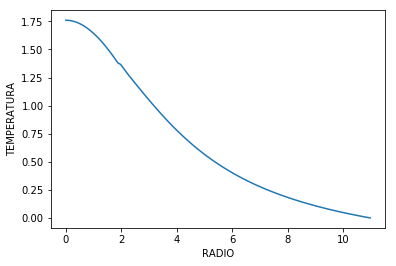

In [65]:
import matplotlib.pyplot as plt
plt.plot(radio,temperatura)
plt.xlabel('RADIO')
plt.ylabel('TEMPERATURA')
plt.show()

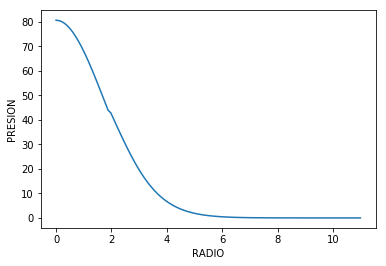

In [66]:
import matplotlib.pyplot as plt
plt.plot(radio,presion)
plt.xlabel('RADIO')
plt.ylabel('PRESION')
plt.show()

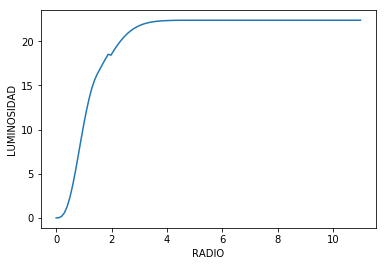

In [67]:
import matplotlib.pyplot as plt
plt.plot(radio,luminosidad)
plt.xlabel('RADIO')
plt.ylabel('LUMINOSIDAD')
plt.show()

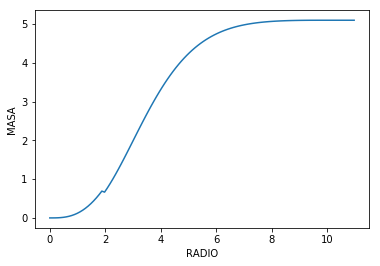

In [68]:
import matplotlib.pyplot as plt
plt.plot(radio,masa)
plt.xlabel('RADIO')
plt.ylabel('MASA')
plt.show()

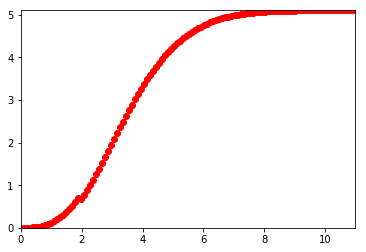

In [69]:
import matplotlib.pyplot as plt
plt.plot(radio, masa, 'ro')
plt.axis([min(radio), max(radio),min(masa), max(masa)])
plt.show()

In [70]:
print(Err_rel_total)

0.2526575677143034
